In [1]:
import sys
print(sys.executable)

/Users/pan/Desktop/BetAI/venv/bin/python


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from typing import List, Union

In [ ]:
def get_industry_crashes(
    industry: str,
    start: str = "2015-01-01",
    end: Union[str, None] = None,
    definition: str = "daily_5pct",
    tickers_dict: dict = None
) -> pd.DataFrame:
    """
    Download stock or index data for a given industry and return crash dates.

    Parameters
    ----------
    industry : str
        Industry name key (must be in tickers_dict).
    start : str
        Start date, e.g. '2015-01-01'.
    end : str or None
        End date (default: today).
    definition : str
        Crash rule:
            - 'daily_3pct' : drop >= 3% in a day
            - 'daily_5pct' : drop >= 5% in a day
            - 'drawdown_10pct' : drawdown >= 10% from 30-day high
    tickers_dict : dict
        Dictionary mapping industries to tickers. If None, uses defaults.

    Returns
    -------
    pd.DataFrame
        DataFrame with crash dates and mean returns.
    """

    if tickers_dict is None:
        tickers_dict = {
            "Technology": ["^NDXT", "^SOX"],
            "Banking": ["^BKX", "^IXB"],
            "Biotech": ["^NBI"],
            "Energy": ["^SPNY", "^XOI"],
            "Consumer Goods": ["^SPLRCD"],
            "Utilities": ["^UTIL"],
            "Transportation": ["^DJT"],
            "Metals & Mining": ["^XME"],
            "Real Estate": ["^RMZ"],
            "Healthcare": ["^SP500-35"],
            "Financials": ["^SP500-40"],
            "Industrial": ["^SP500-20"],
            "Communication Services": ["^SP500-50"],
            "Materials": ["^SP500-15"],
        }

    if industry not in tickers_dict:
        raise ValueError(f"Unknown industry '{industry}'. Available: {list(tickers_dict.keys())}")

    tickers = tickers_dict[industry]

    data = yf.download(tickers, start=start, end=end, auto_adjust=False)['Adj Close']
    if isinstance(data, pd.Series):
        data = data.to_frame()

    returns = data.pct_change()

    if definition == "daily_3pct":
        threshold = -0.03
        crash_mask = (returns <= threshold)
        industry_crash = crash_mask.mean(axis=1) > 0.5
        crash_dates = industry_crash[industry_crash].index

    elif definition == "daily_5pct":
        threshold = -0.05
        crash_mask = (returns <= threshold)
        industry_crash = crash_mask.mean(axis=1) > 0.5
        crash_dates = industry_crash[industry_crash].index

    elif definition == "drawdown_10pct":
        roll_max = data.rolling(30, min_periods=1).max()
        drawdown = (data / roll_max - 1)
        industry_drawdown = drawdown.mean(axis=1)
        crash_dates = industry_drawdown[industry_drawdown <= -0.10].index
    else:
        raise ValueError("Unknown definition. Choose from 'daily_3pct', 'daily_5pct', 'drawdown_10pct'.")

    return pd.DataFrame({
        "CrashDate": crash_dates,
        "Industry": industry,
        "Definition": definition
    })


[*********************100%***********************]  1 of 1 completed


,CrashDate,Industry,Definition
0,2018-10-24,Biotech,daily_5pct
1,2020-03-09,Biotech,daily_5pct
2,2020-03-12,Biotech,daily_5pct
3,2020-03-16,Biotech,daily_5pct
4,2025-04-04,Biotech,daily_5pct


In [ ]:
tickers_dict = {
            "Technology": ["^NDXT", "^SOX"],
            "Banking": ["^BKX", "^IXB"],
            "Biotech": ["^NBI"],
            "Energy": ["^SPNY", "^XOI"],
            "Consumer Goods": ["^SPLRCD"],
            "Utilities": ["^UTIL"],
            "Transportation": ["^DJT"],
            "Metals & Mining": ["^XME"],
            "Real Estate": ["^RMZ"],
            "Healthcare": ["^SP500-35"],
            "Financials": ["^SP500-40"],
            "Industrial": ["^SP500-20"],
            "Communication Services": ["^SP500-50"],
            "Materials": ["^SP500-15"],
        }

In [24]:
industry = "Technology"
tickers = tickers_dict[industry]

df = get_industry_crashes(industry, start="2018-01-01", definition="daily_5pct")
df.head()

[*********************100%***********************]  2 of 2 completed


,CrashDate,Industry,Definition
0,2018-10-24,Technology,daily_5pct
1,2020-03-09,Technology,daily_5pct
2,2020-03-12,Technology,daily_5pct
3,2020-03-16,Technology,daily_5pct
4,2020-03-18,Technology,daily_5pct


[*********************100%***********************]  1 of 1 completed


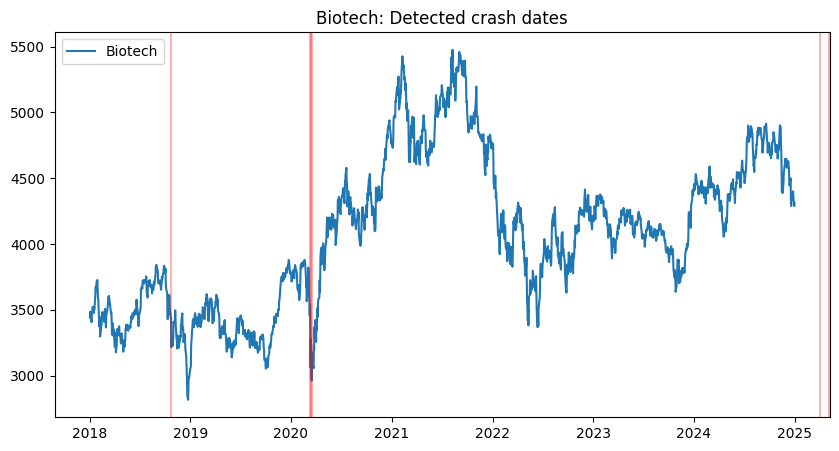

In [23]:
data = yf.download(tickers, start="2018-01-01", end="2025-01-01", auto_adjust=False)['Adj Close']

plt.figure(figsize=(10,5))
plt.plot(data, label=industry)
for d in df["CrashDate"]:
    plt.axvline(d, color="red", alpha=0.3)
plt.legend()
plt.title(f"{industry}: Detected crash dates")
plt.show()
